In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nlmk.dataset import Dataset

import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from collections import Counter
from tqdm import tqdm

np.warnings.filterwarnings("ignore")

In [3]:
RULONI_PATH = "../data/Ruloni.csv"
VALKI_PATH = "../data/Valki.csv"
ZAVALKI_PATH = "../data/Zavalki.csv"
TEST_PATH = "../data/Test.csv"

In [4]:
ds = Dataset(RULONI_PATH, VALKI_PATH, ZAVALKI_PATH, TEST_PATH)

100%|██████████| 269967/269967 [00:02<00:00, 101799.91it/s]


In [5]:
train_X, train_y, valid_X, valid_y = ds.get_train_valid_data()

In [6]:
train_X.head()

,номер_клетки,положение_в_клети,номер_валка,продолжительность_завалки_мин,день_недели,час,материал_валка,сум_Масса,сум_Масса_марки_1,сум_Масса_марки_2,...,ср_Ширина_марки_103,ср_Ширина_марки_104,ср_Ширина_марки_105,ср_Ширина_марки_106,ср_Ширина_марки_107,ср_Ширина_марки_108,ср_Ширина_марки_109,ср_Ширина_марки_110,ср_Ширина_марки_111,число_рулонов
0,8,1,222,197,0,0,6,2482.95,0.0,0.0,...,0.0,0.0,1324.0,0.0,0.0,0.0,1415.0,0.0,0.0,113
1,8,0,260,197,0,0,1,2482.95,0.0,0.0,...,0.0,0.0,1324.0,0.0,0.0,0.0,1415.0,0.0,0.0,113
2,9,1,410,197,0,0,2,2482.95,0.0,0.0,...,0.0,0.0,1324.0,0.0,0.0,0.0,1415.0,0.0,0.0,113
3,9,0,57,197,0,0,1,2482.95,0.0,0.0,...,0.0,0.0,1324.0,0.0,0.0,0.0,1415.0,0.0,0.0,113
4,10,1,273,197,0,0,15,2482.95,0.0,0.0,...,0.0,0.0,1324.0,0.0,0.0,0.0,1415.0,0.0,0.0,113


In [7]:
train_X.shape

(11700, 1508)

In [8]:
def add_del(model, train_X, train_y, valid_X, valid_y, features_init=None):
    features_all = set(train_X.columns)
    features = features_init or set()
    feature_sets = []
    
    last_train_score = np.inf
    last_valid_score = np.inf
    
    while True:
        print("ADD")
        feature, train_score, valid_score = add_one(model, train_X, train_y, valid_X, valid_y, features)
        if valid_score < last_valid_score and not feature.startswith("rnd_"):
            features = features.union({feature})
            feature_sets.append(features)
            last_valid_score = valid_score
            print("\t", feature, "TRAIN SCORE", train_score, "VALID SCORE", valid_score)
        else:
            break
    
    while True:
        print("DEL")
        feature, train_score, valid_score = del_one(model, train_X, train_y, valid_X, valid_y, features)
        if valid_score < last_valid_score and not feature.startswith("rnd_"):
            features = features - {feature}
            feature_sets.append(features)
            last_valid_score = valid_score
            print("\t", feature, "TRAIN SCORE", train_score, "VALID SCORE", valid_score)
        else:
            break
    
    return features

def add_one(model, train_X, train_y, valid_X, valid_y, features):
    features_all = set(train_X.columns)
    features_unused = features_all - features
    
    scores = {}
    for feature in tqdm(features_unused):
        features_new = list(features.union({feature}))
        
        train_X_new = train_X[features_new]
        valid_X_new = valid_X[features_new]
        
        model.fit(
            train_X_new, train_y, 
              eval_set=[(train_X_new, train_y), (valid_X_new, valid_y)],
            verbose=False
        )
        
        idx = np.argmin(model.evals_result()["validation_1"]["rmse"])
        train_score = model.evals_result()["validation_0"]["rmse"][idx]
        valid_score = model.evals_result()["validation_1"]["rmse"][idx]
        
        scores[feature] = train_score, valid_score
    
    best_feature, (train_score, valid_score) = min(scores.items(), key=lambda x: x[1][1])
    return best_feature, train_score, valid_score

def del_one(model, train_X, train_y, valid_X, valid_y, features):
    scores = {}
    for feature in tqdm(features):
        features_new = list(features - {feature})
        
        train_X_new = train_X[features_new]
        valid_X_new = valid_X[features_new]
        
        model.fit(
            train_X_new, train_y, 
            eval_set=[(train_X_new, train_y), (valid_X_new, valid_y)], 
            verbose=False
        )
        
        idx = np.argmin(model.evals_result()["validation_1"]["rmse"])
        train_score = model.evals_result()["validation_0"]["rmse"][idx]
        valid_score = model.evals_result()["validation_1"]["rmse"][idx]
        
        scores[feature] = train_score, valid_score
    
    best_feature, (train_score, valid_score) = min(scores.items(), key=lambda x: x[1][1])
    return best_feature, train_score, valid_score

def add_noisy_features(X, factor=1):
    features_all = set(X.columns)
    idx = np.arange(len(X))
    
    for _ in range(factor):
        for feature in features_all:
            np.random.shuffle(idx)
            X["rnd_" + feature] = X[feature].values[idx]
    
    return X

In [9]:
train_X = add_noisy_features(train_X)
valid_X = add_noisy_features(valid_X)

In [10]:
model = xgb.XGBRegressor(
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=1000, 
    verbosity=0, 
    objective="reg:squarederror", 
    n_jobs=4,
    tree_method="gpu_exact"
)

In [ ]:
features = add_del(model, train_X, train_y, valid_X, valid_y, features_init=set(features))

  0%|          | 0/2999 [00:00<?, ?it/s]

ADD


 13%|█▎        | 393/2999 [05:16<34:49,  1.25it/s]

In [14]:
features

{'макс_Масса_марки_95',
 'материал_валка',
 'мед_Толщина_марки_105',
 'мин_Толщина_марки_105',
 'мин_Толщина_марки_109',
 'номер_клетки',
 'продолжительность_завалки_мин',
 'ср_Масса_марки_75',
 'ср_Масса_марки_80',
 'ср_Толщина',
 'ср_Толщина_марки_109',
 'ср_Толщина_марки_41',
 'сум_Масса_марки_105',
 'сум_Толщина_марки_87',
 'сум_Толщина_марки_95',
 'сум_Ширина_марки_109',
 'сум_Ширина_марки_41'}

In [ ]:
0.321584

In [350]:
features = list(features)

In [297]:
features

['макс_Толщина',
 'продолжительность_завалки_мин',
 'мин_Толщина',
 'ср_Ширина',
 'материал_валка',
 'номер_клетки',
 'ср_Толщина',
 'мин_Ширина',
 'мед_Ширина']

In [12]:
features = [
    "номер_клетки", "продолжительность_завалки_мин", "мин_Толщина_марки_109", "макс_Масса_марки_95",
    "ср_Толщина_марки_41", "материал_валка", "ср_Масса_марки_80", "мин_Толщина_марки_105", "сум_Ширина_марки_41",
    "сум_Толщина_марки_87", "сум_Масса_марки_73", "сум_Масса_марки_105", "ср_Толщина_марки_109", "сум_Ширина_марки_109",
    "ср_Толщина", "сум_Толщина_марки_95", "мед_Толщина_марки_105"
]

In [15]:
model = xgb.XGBRegressor(
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=4000, 
    verbosity=0, 
    objective="reg:squarederror", 
    n_jobs=4,
)

In [16]:
model.fit(
    train_X[features], train_y, 
    eval_set=[(train_X[features], train_y), (valid_X[features], valid_y)],
    verbose=False
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=4000,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

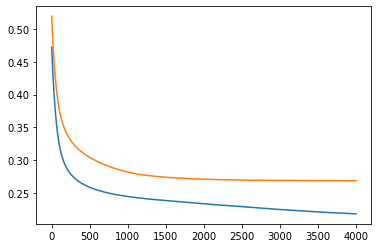

In [17]:
plt.plot(model.evals_result()["validation_0"]["rmse"])
plt.plot(model.evals_result()["validation_1"]["rmse"])

In [18]:
np.argmin(model.evals_result()["validation_1"]["rmse"]), min(model.evals_result()["validation_1"]["rmse"])

(3963, 0.26863)

In [19]:
def linear_calibration(y):
    return np.clip(y * 1.5 - 0.4, 0, None)

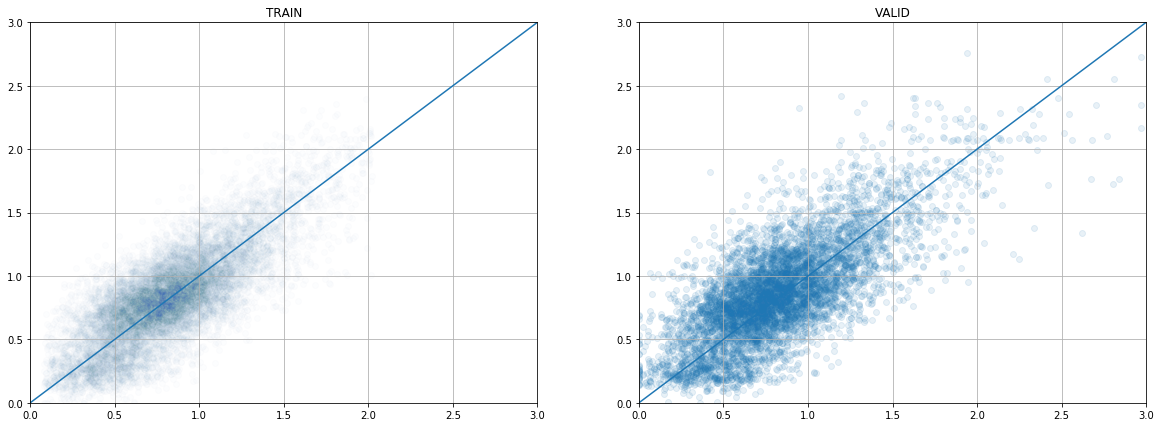

In [20]:
train_pred_y = model.predict(train_X[features])
valid_pred_y = model.predict(valid_X[features])

plt.figure(figsize=[20, 7])

plt.subplot(1, 2, 1)
plt.scatter(train_y, linear_calibration(train_pred_y), alpha=0.01)
plt.plot([0, 3], [0, 3])
plt.title("TRAIN")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(valid_y, linear_calibration(valid_pred_y), alpha=0.1)
plt.plot([0, 3], [0, 3])
plt.title("VALID")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.grid()

In [21]:
np.sqrt(mean_squared_error(valid_y, valid_pred_y))

0.2686336888179469

In [22]:
np.sqrt(mean_squared_error(valid_y, linear_calibration(valid_pred_y)))

0.29033791658620206

In [23]:
train_all_X, train_all_y, test_X = ds.get_train_test_data()

In [21]:
model = xgb.XGBRegressor(
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=4000, 
    verbosity=0, 
    objective="reg:squarederror", 
    n_jobs=4,
)

In [22]:
model.fit(train_X[features], train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=3600,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

In [24]:
test_y = model.predict(test_X[features])

In [396]:
test_y = linear_calibration(test_y)

In [25]:
ds.save_submission_pair("../data/xgb_13.csv", test_y)

In [26]:
Dataset.calc_score(1.03781, 1.03379)

(0.26995991565077115, 0.2699870450777795)

In [ ]:
0.30491, 0.30566, 0.32894, 0.27262, 0.27477, 0.26998